<a href="https://colab.research.google.com/github/Padawanh/WIMyD/blob/main/Como%20usa%20a%20API%20Python%20OpenRouteService%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Instalando e importando Pacotes
!pip install openrouteservice > /dev/null
!pip install folium > /dev/null
!pip install geopandas > /dev/null

import pandas as pd
import time
import geopandas as gp
from shapely.geometry import LineString
import folium
import matplotlib.pyplot as plt
import openrouteservice

# Como usar a API Openrouteservice?

O primeiro passo é criar uma conta e criar uma chave no [openrouteservice.org](https://openrouteservice.org/), a documentação é muito boa ao ponto de eu não querer entrar em detalhes aqui, basicamente você faz um login (pode ser com sua conta do github) vai na aba [Dashboard](https://openrouteservice.org/dev/#/home) para criar uma chave. Na aba API Playground também mostra muita coisa interessante.

## Fazendo uma uma requisicão atraves da [API Python OpenRouteService](https://github.com/GIScience/openrouteservice-py)
Você pode encontrar mais detalhes sobre alguns parâmetros na documentação do  [github](https://giscience.github.io/openrouteservice/) e mais sobre os tipos de roteamento [aqui](https://giscience.github.io/openrouteservice/documentation/Tag-Filtering.html).

In [4]:
key='Sua chave aqui' #Chave da API
client = openrouteservice.Client(key) #Fazendo a conexão com o serviço 
coords = ((-50.184777 , -25.122125),(-48.519270 , -25.503800)) #Coordenadas de origem e destino, pode ter coordenadas intermediárias
 
routes = client.directions(coordinates=coords,
                           profile='driving-hgv', #Tipo de rota, nesse caso é para veiculos de transporte logístico e afins
                           format='geojson', #Formato de saída
                           validate=False,
                           radiuses=5000, #Raio em metros de busca de trechos de estrada próx. as coordendas de referência
                           extra_info=["waycategory", #Categoria de caminho
                                       "waytype", #Tipo de caminho
                                       "surface"] #Tipo de superficie
                           )
#Salvando os resultados em um json
import json
with open('data.json', 'w') as f:
    json.dump(routes, f)

##Geometria e a distância.
Dentro desse arquivo geojson existe muitas coisas, porém vou ressaltar duas, a geometria e a distância

214.57 km


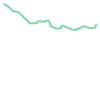

In [5]:
# A quantidade de quilometros da rota e as coordenadas que compõem a geometria da linha
dist = str(round(routes['features'][0]['properties']['summary']['distance']/1000,2))+" km"
print(dist)
LineString(routes['features'][0]['geometry']['coordinates'])

Também é possível ver outros atributos extras da rota, mas tem que indicar no momento da requisição, veja aqui na [documentação](https://giscience.github.io/openrouteservice/documentation/extra-info/Extra-Info.html).

In [6]:
routes['features'][0]['properties']['extras']

{'waycategory': {'values': [[0, 60, 0],
   [60, 333, 1],
   [333, 340, 3],
   [340, 473, 1],
   [473, 477, 3],
   [477, 1149, 1],
   [1149, 1153, 3],
   [1153, 1632, 1],
   [1632, 1739, 0]],
  'summary': [{'value': 1.0, 'distance': 198082.9, 'amount': 92.32},
   {'value': 0.0, 'distance': 15033.6, 'amount': 7.01},
   {'value': 3.0, 'distance': 1449.3, 'amount': 0.68}]},
 'surface': {'values': [[0, 11, 3],
   [11, 12, 1],
   [12, 1723, 3],
   [1723, 1735, 1],
   [1735, 1736, 3],
   [1736, 1739, 1]],
  'summary': [{'value': 3.0, 'distance': 213387.1, 'amount': 99.45},
   {'value': 1.0, 'distance': 1178.7, 'amount': 0.55}]},
 'waytypes': {'values': [[0, 1710, 1], [1710, 1739, 2]],
  'summary': [{'value': 1.0, 'distance': 212226.7, 'amount': 98.91},
   {'value': 2.0, 'distance': 2339.1, 'amount': 1.09}]}}

Se verificarmos o tipo de superficie encontramos o tipo 3 e 1, que são asfalto e pavimentada respectivamente.

In [7]:
routes['features'][0]['properties']['extras']['surface']['summary']

[{'value': 3.0, 'distance': 213387.1, 'amount': 99.45},
 {'value': 1.0, 'distance': 1178.7, 'amount': 0.55}]

In [8]:
#@title Dando uma olhada com o folium.
#@markdown Interessante que ele prefere ir pelo anel rodoviário de Curitiba, que não é a rota mais curta porém é recomendado para o tipo de transporte que  foi parametrizado


m = folium.Map(location=[-25.431910, -49.400217], tiles='cartodbpositron', zoom_start=9)

folium.Marker((coords[0][1] , coords[0][0]), tooltip='Ponta Grossa, PR',icon=folium.Icon(color='green', icon='info-sign')).add_to(m)
folium.Marker((coords[1][1] , coords[1][0]), tooltip='Porto de Paranaguá, PR',icon=folium.Icon(color='red', icon='info-sign')).add_to(m)
folium.PolyLine(locations=[list(reversed(coord)) 
                           for coord in 
                           routes['features'][0]['geometry']['coordinates']], tooltip=dist).add_to(m)
    
m

## E se eu quiser saber a rota de várias origens e destinos de uma vez só?

In [9]:
#Primeiro vou montar um DataFrame com as origens e destinos
DataTable = {'Rota': ['Imbaú, PR - Ponta Grossa, PR', 'Ponta Grossa, PR - Curitiba, PR'],
     'OrigemLong':[-50.7516409,-50.2396862],
     'OrigemLat':[-24.4603571,-25.0622996],
     'DestinoLong':[-50.2396862,-49.337566],
     'DestinoLat':[-25.0622996,-25.431829],
     }
df = pd.DataFrame(data=DataTable)
df


,Rota,OrigemLong,OrigemLat,DestinoLong,DestinoLat
0,"Imbaú, PR - Ponta Grossa, PR",-50.751641,-24.460357,-50.239686,-25.062300
1,"Ponta Grossa, PR - Curitiba, PR",-50.239686,-25.062300,-49.337566,-25.431829


Com a função abaixo eu consigo pegar as informações desse DataFrame e pedir para extrair do serviço a informação da distância e da geometria e criar um GeoDataFrame com as rotas, a lógica das informações é igual a anterior, só que vou linha a linha capturando as informações e fazendo as solicitações e depois adiciono elas como novas colunas no DataFrame

In [10]:
def openrouteservice_dist(df,                         #DataFrame
                          OrigemLong,                 #Longitude da origem
                          OrigemLat,                  #Latitude da origem
                          DestinoLong,                #Longitude do destino
                          DestinoLat,                 #Latitude do destino
                          key,                        #Chave da API
                          radiuses=5000,              #Raio de busca de estradas
                          profile='driving-hgv',      #Tipo ded roteamento
                          printprocess=False):        #Printar em que linha está roteando
                          
  dist = []
  geo = []

  for i in df.index:
    coords = ((df[OrigemLong][i],df[OrigemLat][i]),(df[DestinoLong][i],df[DestinoLat][i]))
    client = openrouteservice.Client(key=key) 
    routes = client.directions(coordinates=coords,
                               profile=profile,
                               format='geojson',
                               validate=False,
                               radiuses=radiuses)
    dist.append(round(routes['features'][0]['properties']['summary']['distance']/1000,2))
    geo.append(LineString(routes['features'][0]['geometry']['coordinates']))
    time.sleep(2)
    if printprocess:
      print(i)
  df['Dist'] = dist
  df['geometry']=geo
  df = gp.GeoDataFrame(df)
  return df

In [18]:
df = openrouteservice_dist(df,
                           'OrigemLong',
                           'OrigemLat',
                           'DestinoLong',
                           'DestinoLat',
                           key,
                           radiuses=5000,
                           profile='driving-hgv')
df

,Rota,OrigemLong,OrigemLat,DestinoLong,DestinoLat,Dist,geometry
0,"Imbaú, PR - Ponta Grossa, PR",-50.751641,-24.460357,-50.239686,-25.062300,95.01,"LINESTRING (-50.75164 -24.46035, -50.75110 -24..."
1,"Ponta Grossa, PR - Curitiba, PR",-50.239686,-25.062300,-49.337566,-25.431829,118.79,"LINESTRING (-50.24066 -25.05980, -50.23990 -25..."


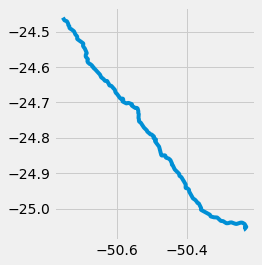

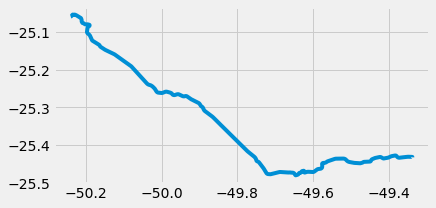

In [24]:
plt.style.use('fivethirtyeight')
df[:1].plot()
df[1:].plot()

In [25]:
#Criando uma Shapefile das rotas geradas
df.set_crs(epsg=4326).to_file('routes.shp')  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  


## De bonûs também posso ter resultados parecidos fazendo requests sem ter que usar a API Python do OpenRouteService

In [26]:
import requests

body = {"locations":[[9.70093,48.477473],[9.207916,49.153868],[37.573242,55.801281],[115.663757,38.106467]],"metrics":["distance"],"units": "km"}

headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': 'Sua chave aqui',
    'Content-Type': 'application/json; charset=utf-8'
}
call = requests.post('https://api.openrouteservice.org/v2/matrix/driving-hgv', json=body, headers=headers)

print(call.status_code, call.reason)
print(call.text)

200 OK
{"distances":[[0.0,137.17,2386.22,10258.43],[141.5,0.0,2335.96,10208.17],[2384.04,2334.99,0.0,7924.08],[10251.58,10202.53,7917.93,0.0]],"destinations":[{"location":[9.694357,48.478627],"snapped_distance":501.18},{"location":[9.207772,49.153882],"snapped_distance":10.57},{"location":[37.572963,55.801279],"snapped_distance":17.45},{"location":[115.665017,38.100717],"snapped_distance":648.79}],"sources":[{"location":[9.694357,48.478627],"snapped_distance":501.18},{"location":[9.207772,49.153882],"snapped_distance":10.57},{"location":[37.572963,55.801279],"snapped_distance":17.45},{"location":[115.665017,38.100717],"snapped_distance":648.79}],"metadata":{"attribution":"openrouteservice.org | OpenStreetMap contributors","service":"matrix","timestamp":1665950169750,"query":{"locations":[[9.70093,48.477473],[9.207916,49.153868],[37.573242,55.801281],[115.663757,38.106467]],"profile":"driving-hgv","responseType":"json","metricsStrings":["DISTANCE"],"metrics":["distance"],"units":"km"},"

# Considerações finais 

*   O resultado das consultas é detalhado e bem parametrizavel.
*   Existe um limite de consultas do plano gratuito (2000/Dia e 40/min), porém é um projeto Open Source, e existe uma [documentação](https://giscience.github.io/openrouteservice/installation/Installation-and-Usage.html) de instalação.

* É uma solução mais rápida e de melhor desempenho do que a do meu último post sobre roteamento, você pode dar uma olhada nele [aqui](https://www.wimyd.com.br/post/roteamento-com-python)